In [30]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from datasets import load_dataset
import re

In [19]:
tinyllama_tokenizer = AutoTokenizer.from_pretrained("unsloth/tinyllama-bnb-4bit")
mistral7b_tokenizer = AutoTokenizer.from_pretrained("unsloth/mistral-7b-v0.3-bnb-4bit")   

c:\Users\Lenovo\miniconda3\envs\assamese\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--unsloth--mistral-7b-v0.3-bnb-4bit. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [31]:
txt_dataset = load_dataset("text", data_files={"txt": "datasets/cleaned_dataset.txt"})["txt"]
parquet_dataset = load_dataset("parquet", data_files={"parquet": "datasets/train-00000-of-00001.parquet"})["parquet"]

In [32]:
assamese_pattern = re.compile(r'[\u0980-\u09FF]+')

def extract_assamese(text):
    """Extracts only Assamese characters from the text."""
    return " ".join(assamese_pattern.findall(text))

# Extract and clean text
txt_data = [extract_assamese(item["text"]) for item in txt_dataset]
parquet_data = [extract_assamese(item["text"]) for item in parquet_dataset]

# Combine the cleaned datasets
combined_data = txt_data + parquet_data

# Remove empty lines and strip spaces
combined_data = [line.strip() for line in combined_data if line.strip()]

# Save to a text file
output_file = "datasets/merged_assamese_corpus.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for line in combined_data:
        f.write(line + "\n")

print(f"Cleaned Assamese corpus saved to {output_file}")

Cleaned Assamese corpus saved to datasets/merged_assamese_corpus.txt


In [28]:
# Count words in the text dataset
def count_words_txt(dataset):
    word_count = 0
    for example in dataset:
        if "text" in example:  # Check if the text column exists
            word_count += len(example["text"].split())
    return word_count

# Count words in the parquet dataset
def count_words_parquet(dataset):
    word_count = 0
    for example in dataset:
        for value in example.values():
            if isinstance(value, str):  # Count words only in string columns
                word_count += len(value.split())
    return word_count

# Get the word counts
txt_word_count = count_words_txt(txt_dataset)
parquet_word_count = count_words_parquet(parquet_dataset)

# Print the results
print(f"Word count in TXT dataset: {txt_word_count}")
print(f"Word count in Parquet dataset: {parquet_word_count}")

Word count in TXT dataset: 4318216
Word count in Parquet dataset: 5102462


In [20]:
llama_tokens = [tinyllama_tokenizer(text['text'], return_tensors="pt")["input_ids"].size(1) for text in txt_dataset]
llama_parquet_tokens = [tinyllama_tokenizer(text['text'], return_tensors="pt")["input_ids"].size(1) for text in parquet_dataset]

In [21]:
mistral_tokens = [mistral7b_tokenizer(text['text'], return_tensors="pt")["input_ids"].size(1) for text in txt_dataset]
mistral_parquet_tokens = [mistral7b_tokenizer(text['text'], return_tensors="pt")["input_ids"].size(1) for text in parquet_dataset]

In [22]:
def basic_stats(dataset, tokens, name):
    print(f"\n--- {name} Dataset Analysis ---")
    print(f"Total sentences: {len(dataset)}")
    print(f"Total tokens: {sum(tokens)}")
    print(f"Average tokens per sentence: {sum(tokens) / len(tokens):.2f}")
    print(f"Average sentence length: {sum(len(text['text']) for text in dataset) / len(dataset):.2f} characters")

    # Plot token distribution
    plt.figure(figsize=(12, 6))
    plt.hist(tokens, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Token Length Distribution in {name} Dataset")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


--- TXT Dataset Analysis ---
Total sentences: 444967
Total tokens: 41566044
Average tokens per sentence: 93.41
Average sentence length: 60.97 characters


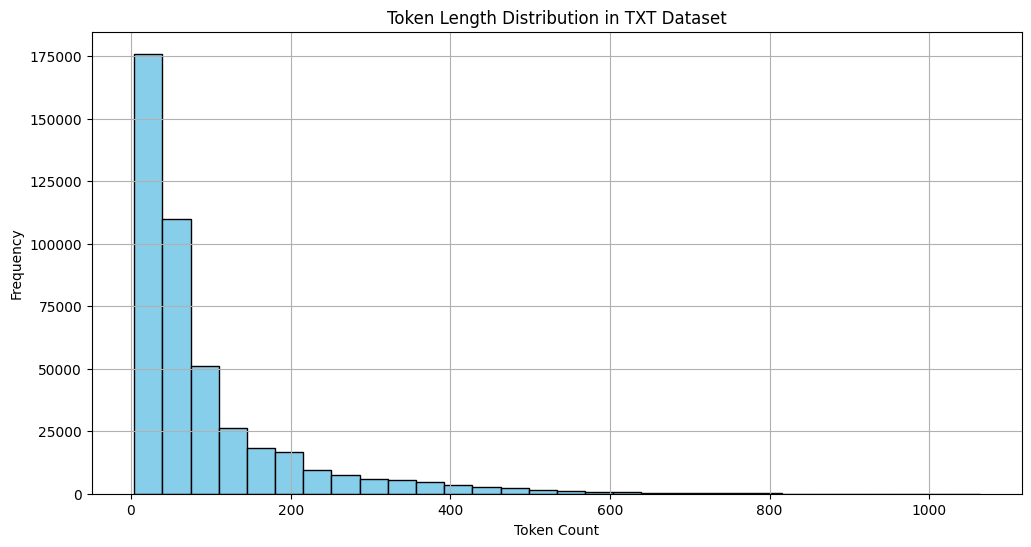


--- Parquet Dataset Analysis ---
Total sentences: 12338
Total tokens: 48322571
Average tokens per sentence: 3916.56
Average sentence length: 2769.98 characters


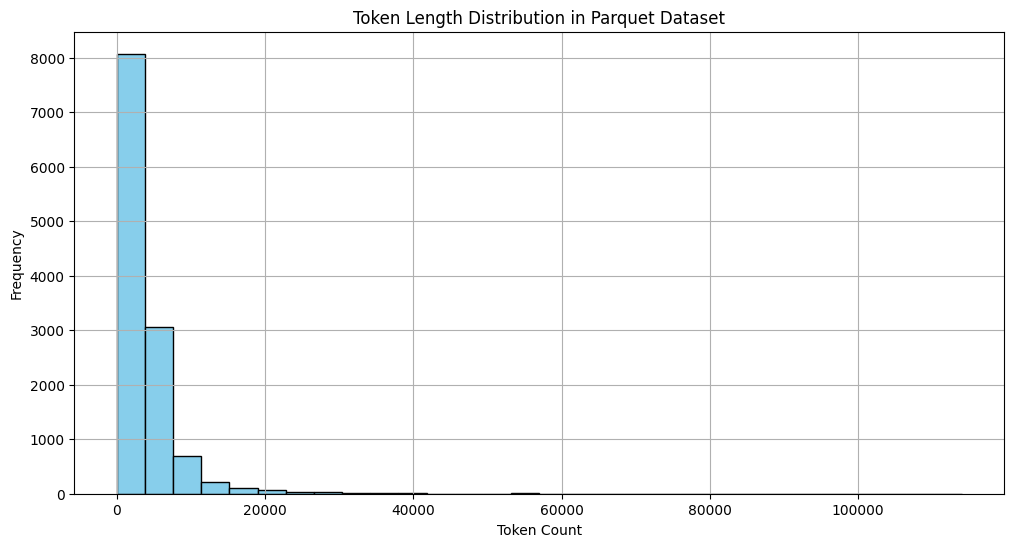

In [23]:
basic_stats(txt_dataset, llama_tokens, "TXT")
basic_stats(parquet_dataset, llama_parquet_tokens, "Parquet")


--- TXT Dataset Analysis ---
Total sentences: 444967
Total tokens: 37173093
Average tokens per sentence: 83.54
Average sentence length: 60.97 characters


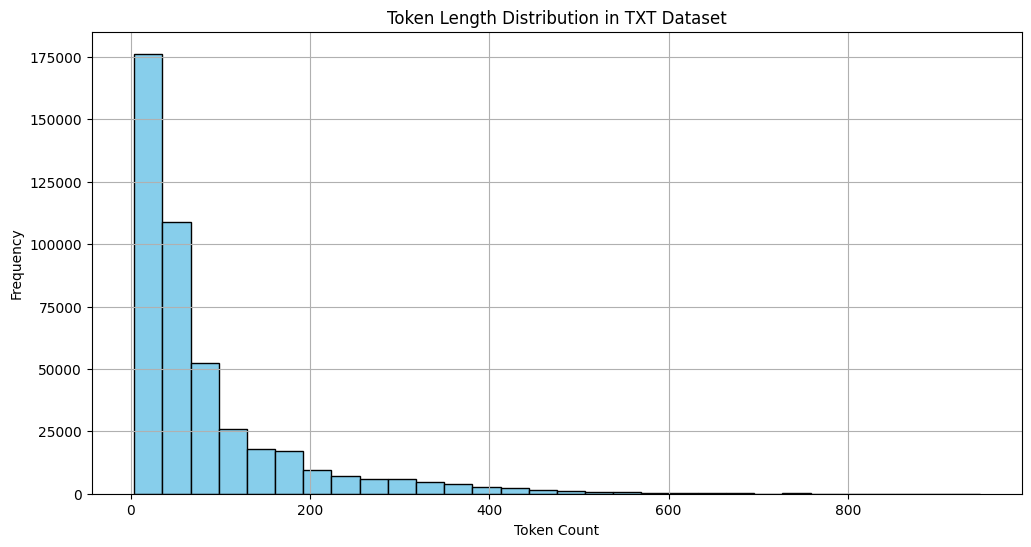


--- Parquet Dataset Analysis ---
Total sentences: 12338
Total tokens: 43521861
Average tokens per sentence: 3527.46
Average sentence length: 2769.98 characters


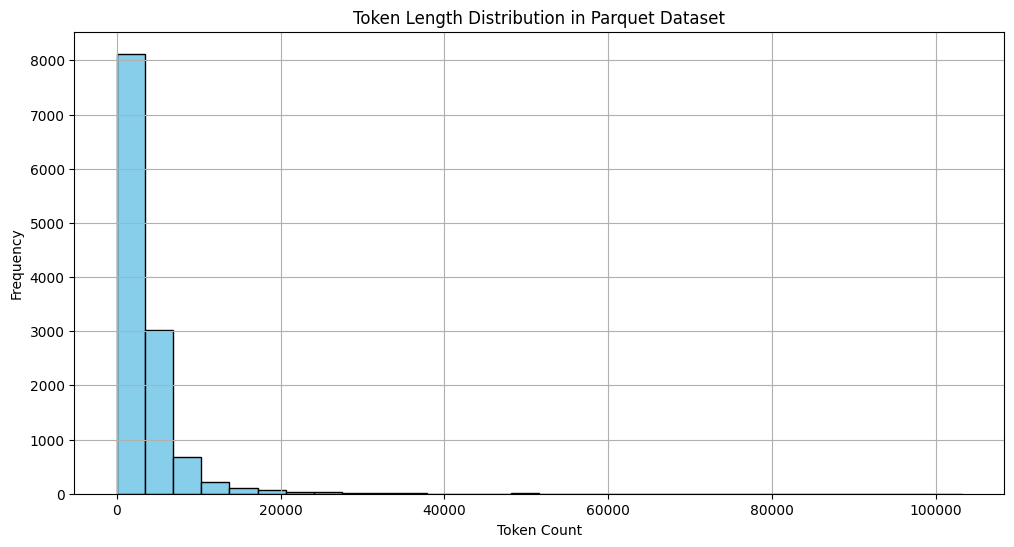

In [25]:
basic_stats(txt_dataset, mistral_tokens, "TXT")
basic_stats(parquet_dataset, mistral_parquet_tokens, "Parquet")

In [18]:
# --- Sample Tokenized Sentences ---
def show_sample_tokens(dataset, name, n=5):
    print(f"\n--- Sample Tokenized Sentences from {name} ---")
    for i, text in enumerate(dataset.select(range(n))):
        tokens = tokenizer(text['text']).tokens()
        print(f"\nSentence {i+1}:")
        print(f"Text: {text['text']}")
        print(f"Tokens: {tokens}")

In [26]:
# Load the tokenizer
tiny = tinyllama_tokenizer.get_vocab()
mistral = mistral7b_tokenizer.get_vocab()

# Check if Assamese characters are in the vocabulary
vowels = ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ']
consonants = ['ক', 'খ', 'গ', 'ঘ', 'ঙ',  
              'চ', 'ছ', 'জ', 'ঝ', 'ঞ',  
              'ট', 'ঠ', 'ড', 'ঢ', 'ণ',  
              'ত', 'থ', 'দ', 'ধ', 'ন',  
              'প', 'ফ', 'ব', 'ভ', 'ম',  
              'য', 'ৰ', 'ল', 'শ', 'ষ', 'স', 'হ',  
              'ক্ষ']  # Complex consonant

digits = ['০', '১', '২', '৩', '৪',  
          '৫', '৬', '৭', '৮', '৯']

vowel_signs = ['া', 'ি', 'ী',  
               'ু', 'ূ', 'ৃ',  
               'ে', 'ৈ', 'ো', 'ৌ']
symbols = ['ঁ', 'ং', 'ঃ', 'ऽ', '।', '॥']

all_assamese_chars = vowels + consonants + vowel_signs + digits + symbols


total = 0
not_in = []
in_vocab = 0
not_in_vocab = 0
for char in all_assamese_chars:
    total += 1
    if char in tiny:
        in_vocab += 1
    else:
        not_in_vocab += 1
        not_in.append(char)

print("\n--- Assamese Characters in tinyllama Vocabulary ---")
print(f"Total characters: {total}")
print(f"Characters in vocabulary: {in_vocab}")
print(f"Characters not in vocabulary: {not_in_vocab}")
print(f"Characters not in vocabulary: {not_in}")


total = 0
not_in = []
in_vocab = 0
not_in_vocab = 0
for char in all_assamese_chars:
    total += 1
    if char in mistral:
        in_vocab += 1
    else:
        not_in_vocab += 1
        not_in.append(char)

print("\n--- Assamese Characters in mistral7b Vocabulary ---")
print(f"Total characters: {total}")
print(f"Characters in vocabulary: {in_vocab}")
print(f"Characters not in vocabulary: {not_in_vocab}")
print(f"Characters not in vocabulary: {not_in}")


--- Assamese Characters in tinyllama Vocabulary ---
Total characters: 70
Characters in vocabulary: 21
Characters not in vocabulary: 49
Characters not in vocabulary: ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'খ', 'ঘ', 'ঙ', 'চ', 'ছ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'থ', 'ধ', 'ফ', 'ভ', 'ৰ', 'ষ', 'ক্ষ', 'ূ', 'ৃ', 'ৈ', 'ৌ', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', 'ঁ', 'ং', 'ঃ', 'ऽ', '॥']

--- Assamese Characters in mistral7b Vocabulary ---
Total characters: 70
Characters in vocabulary: 31
Characters not in vocabulary: 39
Characters not in vocabulary: ['ঈ', 'উ', 'ঊ', 'ঋ', 'ঐ', 'ও', 'ঔ', 'খ', 'ঘ', 'ঙ', 'ছ', 'ঝ', 'ঞ', 'ঠ', 'ঢ', 'ণ', 'থ', 'ধ', 'ফ', 'ৰ', 'ক্ষ', 'ূ', 'ৃ', 'ৈ', 'ৌ', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', 'ঁ', 'ঃ', 'ऽ', '॥']


# Seriously need to train tinyllama 1.1B tokenizer

### Update: Also check Mistral7b's vocab, we are F***ED!!🫡🫡